# Winery by Varietal Review Counts

In this notebook we'll explore wineries based on the kinds of wines that it makes. To do this, for each winery, we'll take the list of varietals that were reviewed, and embed the list into a 2d representation. 

This is an example of embedding **variable width categorical data** where **counts matter**.

In [ ]:
#Quick cell to make jupyter notebook use the full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
#Some plotting libraries
import matplotlib.pyplot as plt
%matplotlib notebook
from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE 
output_notebook(resources=INLINE)

In [ ]:
from src import workflow
from src.data import Dataset
from src import paths

In [ ]:
import umap
import umap.plot
from vectorizers import NgramVectorizer
import numpy as np

## Get Data

In [ ]:
ds = Dataset.from_catalog('wine_reviews_130k')

In [ ]:
print(ds)

In [ ]:
print(ds.DESCR)

In [ ]:
df = ds.data
df.head()

## Getting the Data in the Right Format

This time we want one row per winery, and we want to compare the wineries based on the varietals that they make.

This is a job for groupby.  We groupby the column we'd like to embed and then use agg with a dictionary of column names to aggregation functions to tell it how to summarize the many reviews about a single beer into one record.  Aggregation functions are pretty much any function that takes an iterable and returns a single value.  Median and max are great functions for dealing with numeric fields.

Note that we'll want to drop out entries that don't have a recorded variety as well (there's only one of these!)

In [ ]:
df.variety.value_counts(dropna=False)

In [ ]:
df_variety = df.dropna(axis=0, subset=['variety'])

In [ ]:
winery = df_variety.groupby('winery').agg({
    'winery':'count',
    'country':lambda x: list(x.unique())[0],
    'province':lambda x: list(x.unique())[0],
    'price':'mean',
    'points':'mean',
    'variety': [list, len, lambda x:x.mode().iloc[0]],
}).reset_index()
winery.columns = """winery num_reviews country province price points
varietal_list num_varietals favourite_varietal""".split()

In [ ]:
winery

## First step of the embedding: Vectorization

We are going to vectorize our `varietal_list` data. This step turns the list of varietals into a sparse matrix of counts. One row per row of our data frame and one column per unique token that appeared in our categorical field of interest (in this case, varietals).

We'll use `NgramVectorizer` to turn the `varietal_list` into a vector that counts the number of times each varietal appears in the `varietal_list`.


We use `min_document_occurrences=5` in our `NgramVectorizer` to only count varietals that had at least 10 reviews. Here a *document* corresponds to a *winery*. 

In [ ]:
winery_by_varietal_vectorizer = NgramVectorizer(min_document_occurrences=10)
winery_by_varietal = winery_by_varietal_vectorizer.fit_transform(winery.varietal_list)

In [ ]:
winery_by_varietal.shape

## Next step: Dimension Reduction
Now that we have a numerical representation, we can reduce dimension to get our desired low-dimensional embedding. We'll make ours 2d for easy visualization.

We're in a situation where **counts matter**, as we're considering wineries as being represented by the varietals that it makes. Thus, we'll use `hellinger` for our metric.

In [ ]:
%%time
winery_by_varietal_model = umap.UMAP(n_neighbors=10, n_components=2, metric='hellinger',
                                  unique=True, random_state=42).fit(winery_by_varietal)

In [ ]:
path_to_figures = paths['project_path'] / 'reports' / 'figures'
root_filename = 'winery_by_varietal_hellinger'
outfile_png = path_to_figures / (root_filename + '.png')
outfile_html = path_to_figures / (root_filename + '.html')

In [ ]:
umap_plot = umap.plot.points(winery_by_varietal_model, labels=winery.favourite_varietal, theme='fire', show_legend=False);
#umap_plot.figure.savefig(outfile_png, dpi=300, bbox_inches='tight')

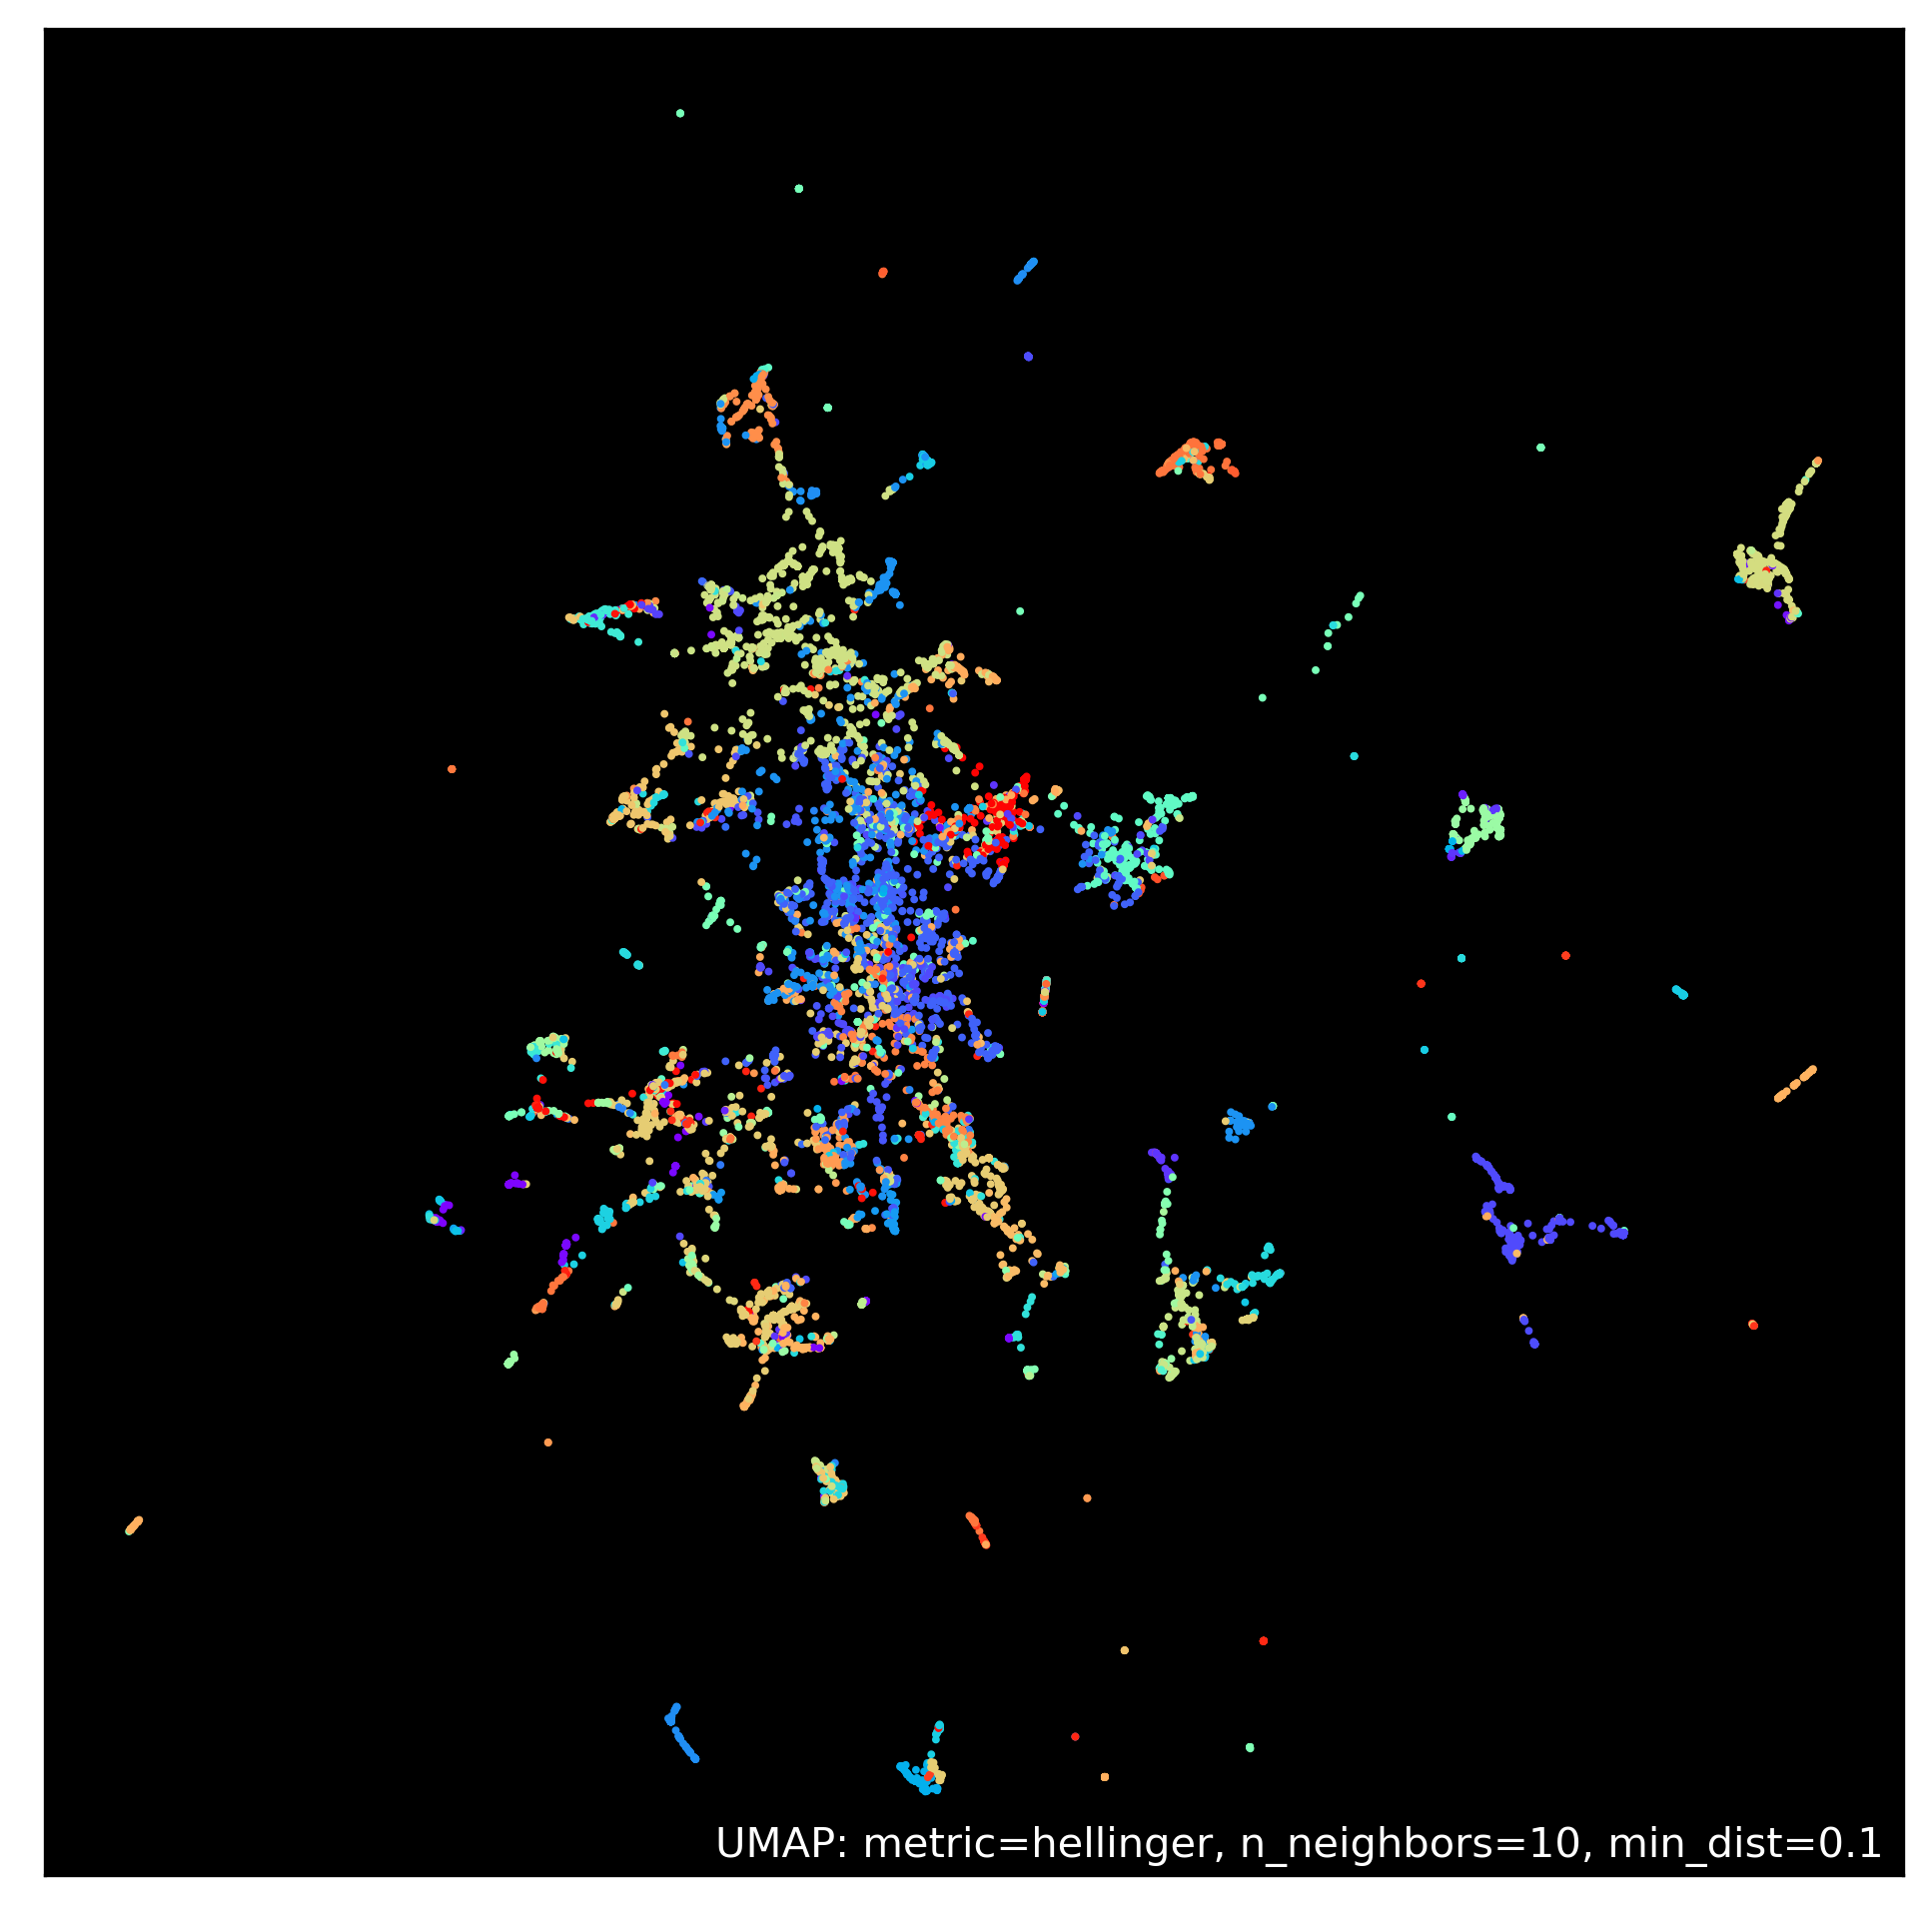

The winery by varietal seems to capture location data as well! For example, the country:

In [ ]:
umap_plot = umap.plot.points(winery_by_varietal_model, labels=winery.country.astype(str), theme='fire', show_legend=False);
#umap_plot.figure.savefig(path_to_figures / 'winery_country_by_varietal_hellinger.png', dpi=300, bbox_inches='tight')

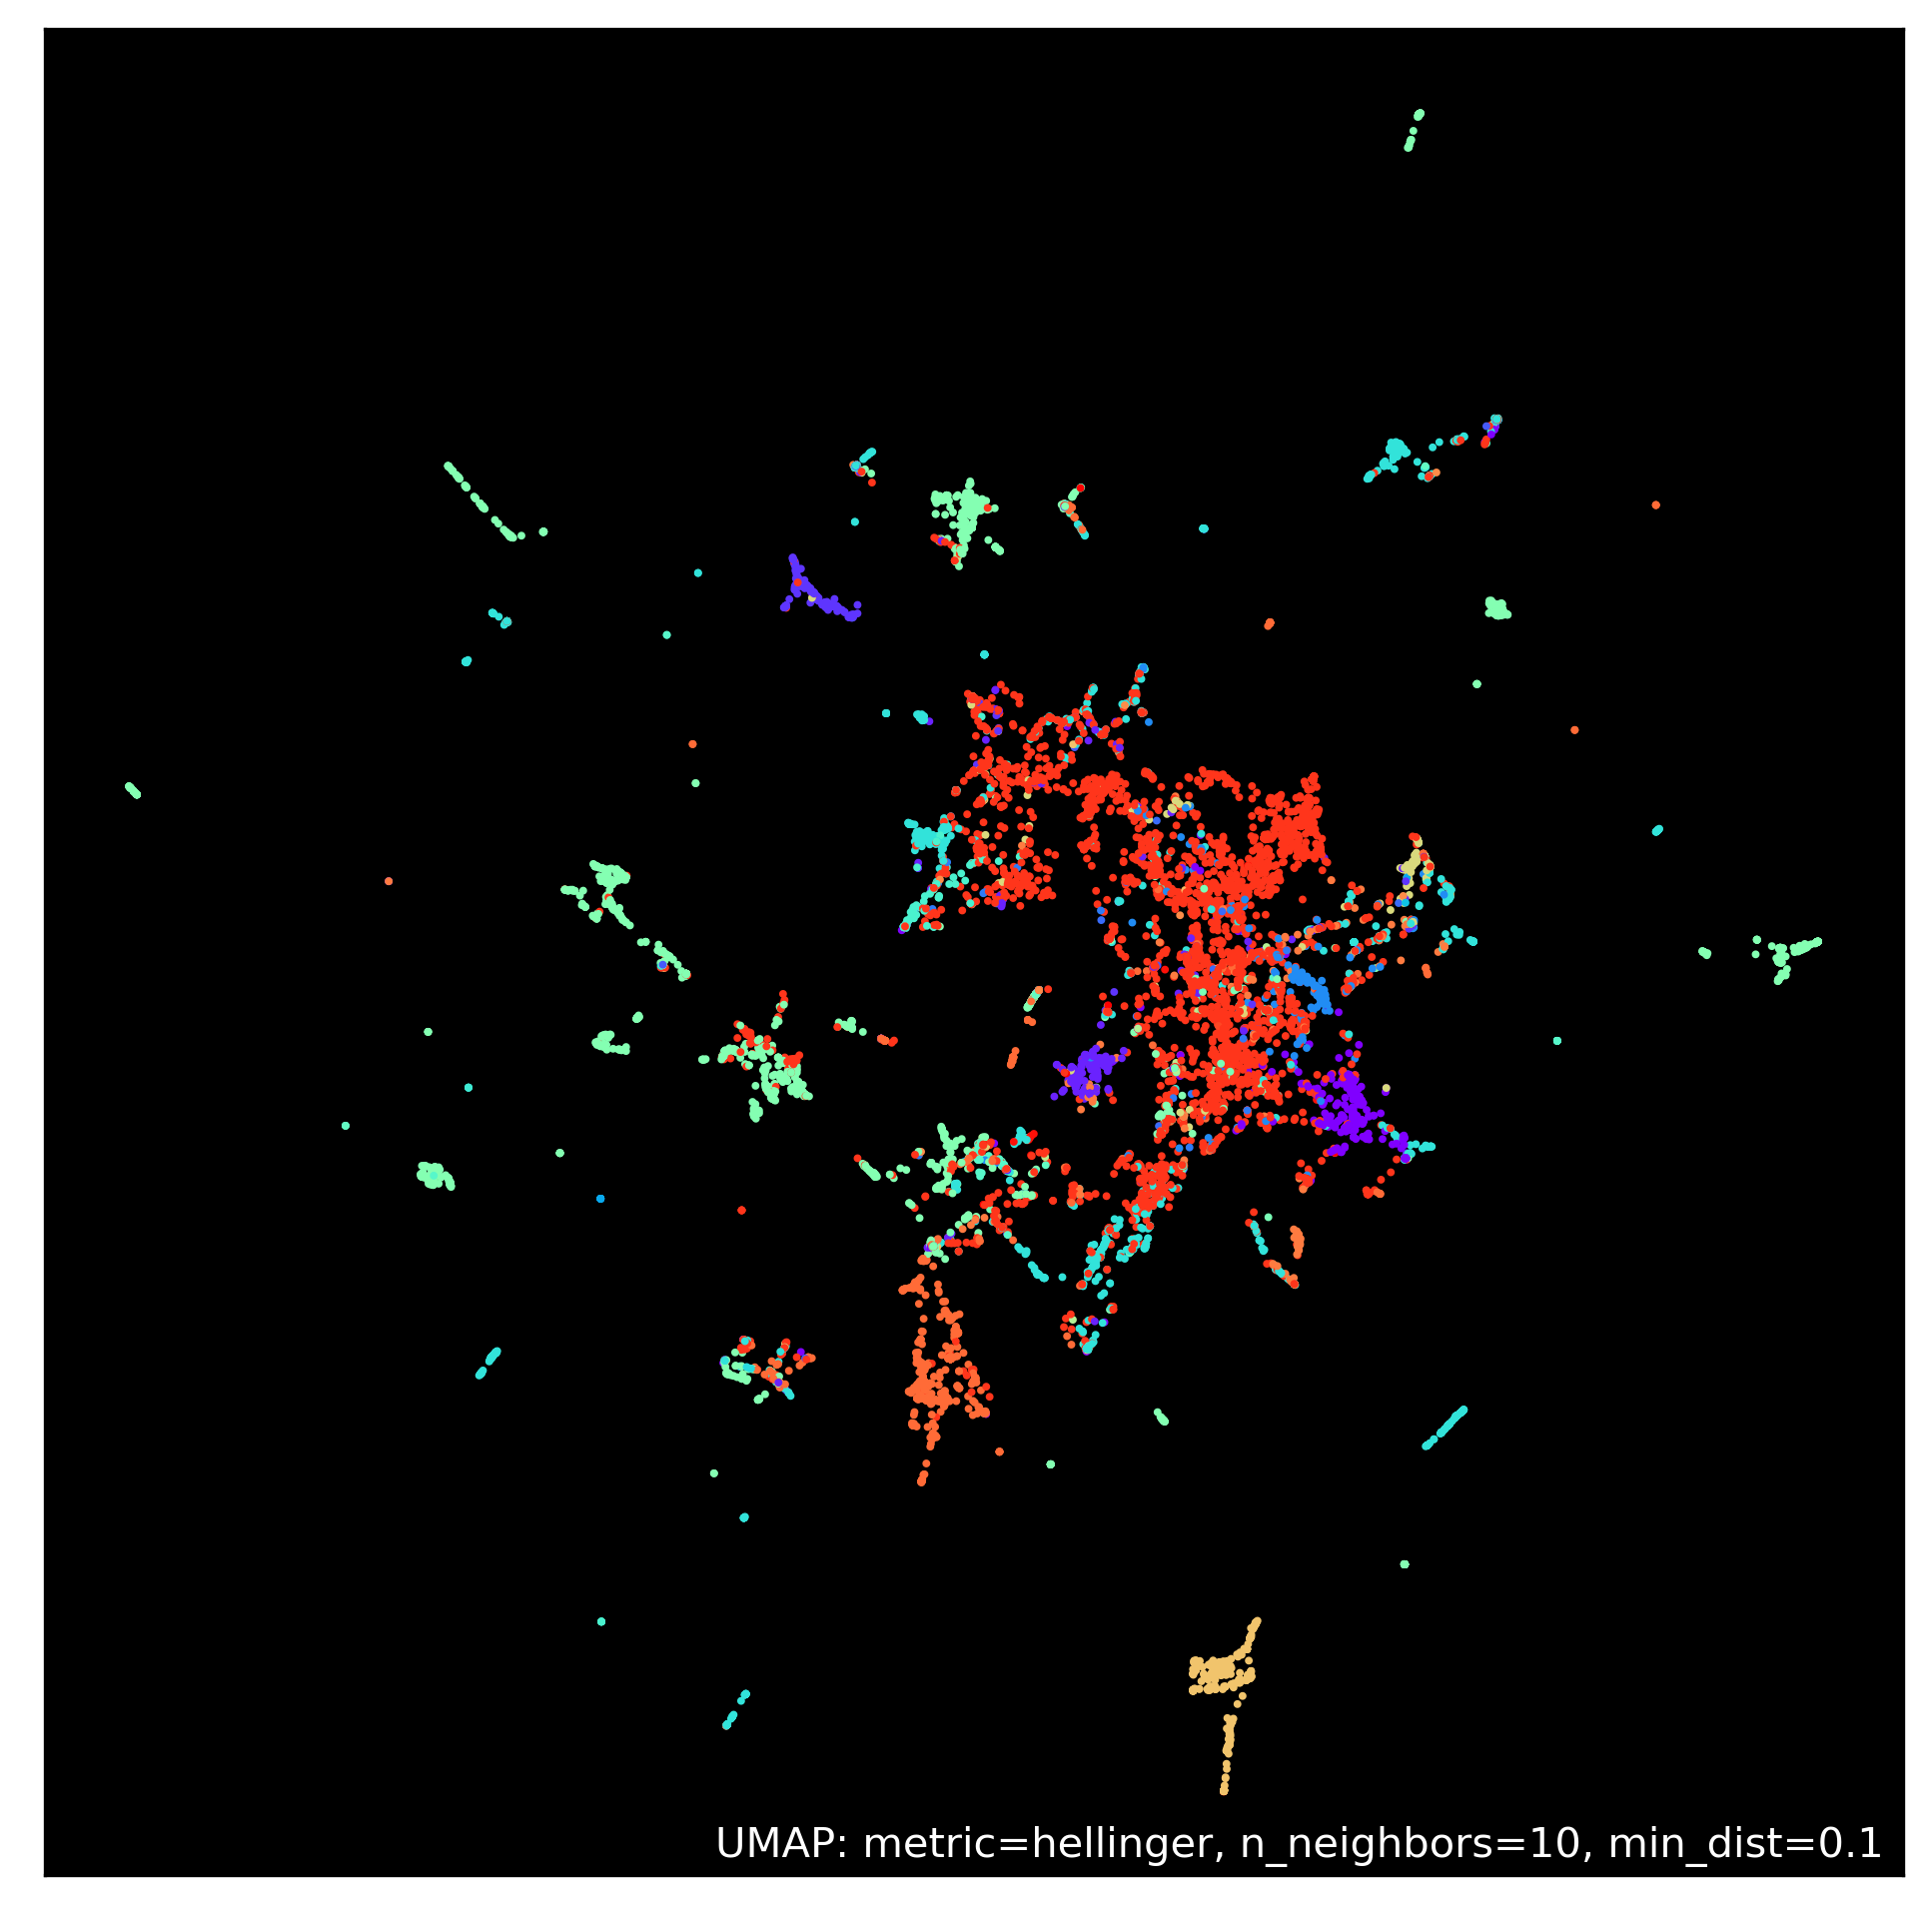

And province:

In [ ]:
umap_plot = umap.plot.points(winery_by_varietal_model, labels=winery.province.astype(str), theme='fire', show_legend=False);
#umap_plot.figure.savefig(path_to_figures / 'winery_province_by_varietal_hellinger.png', dpi=300, bbox_inches='tight')

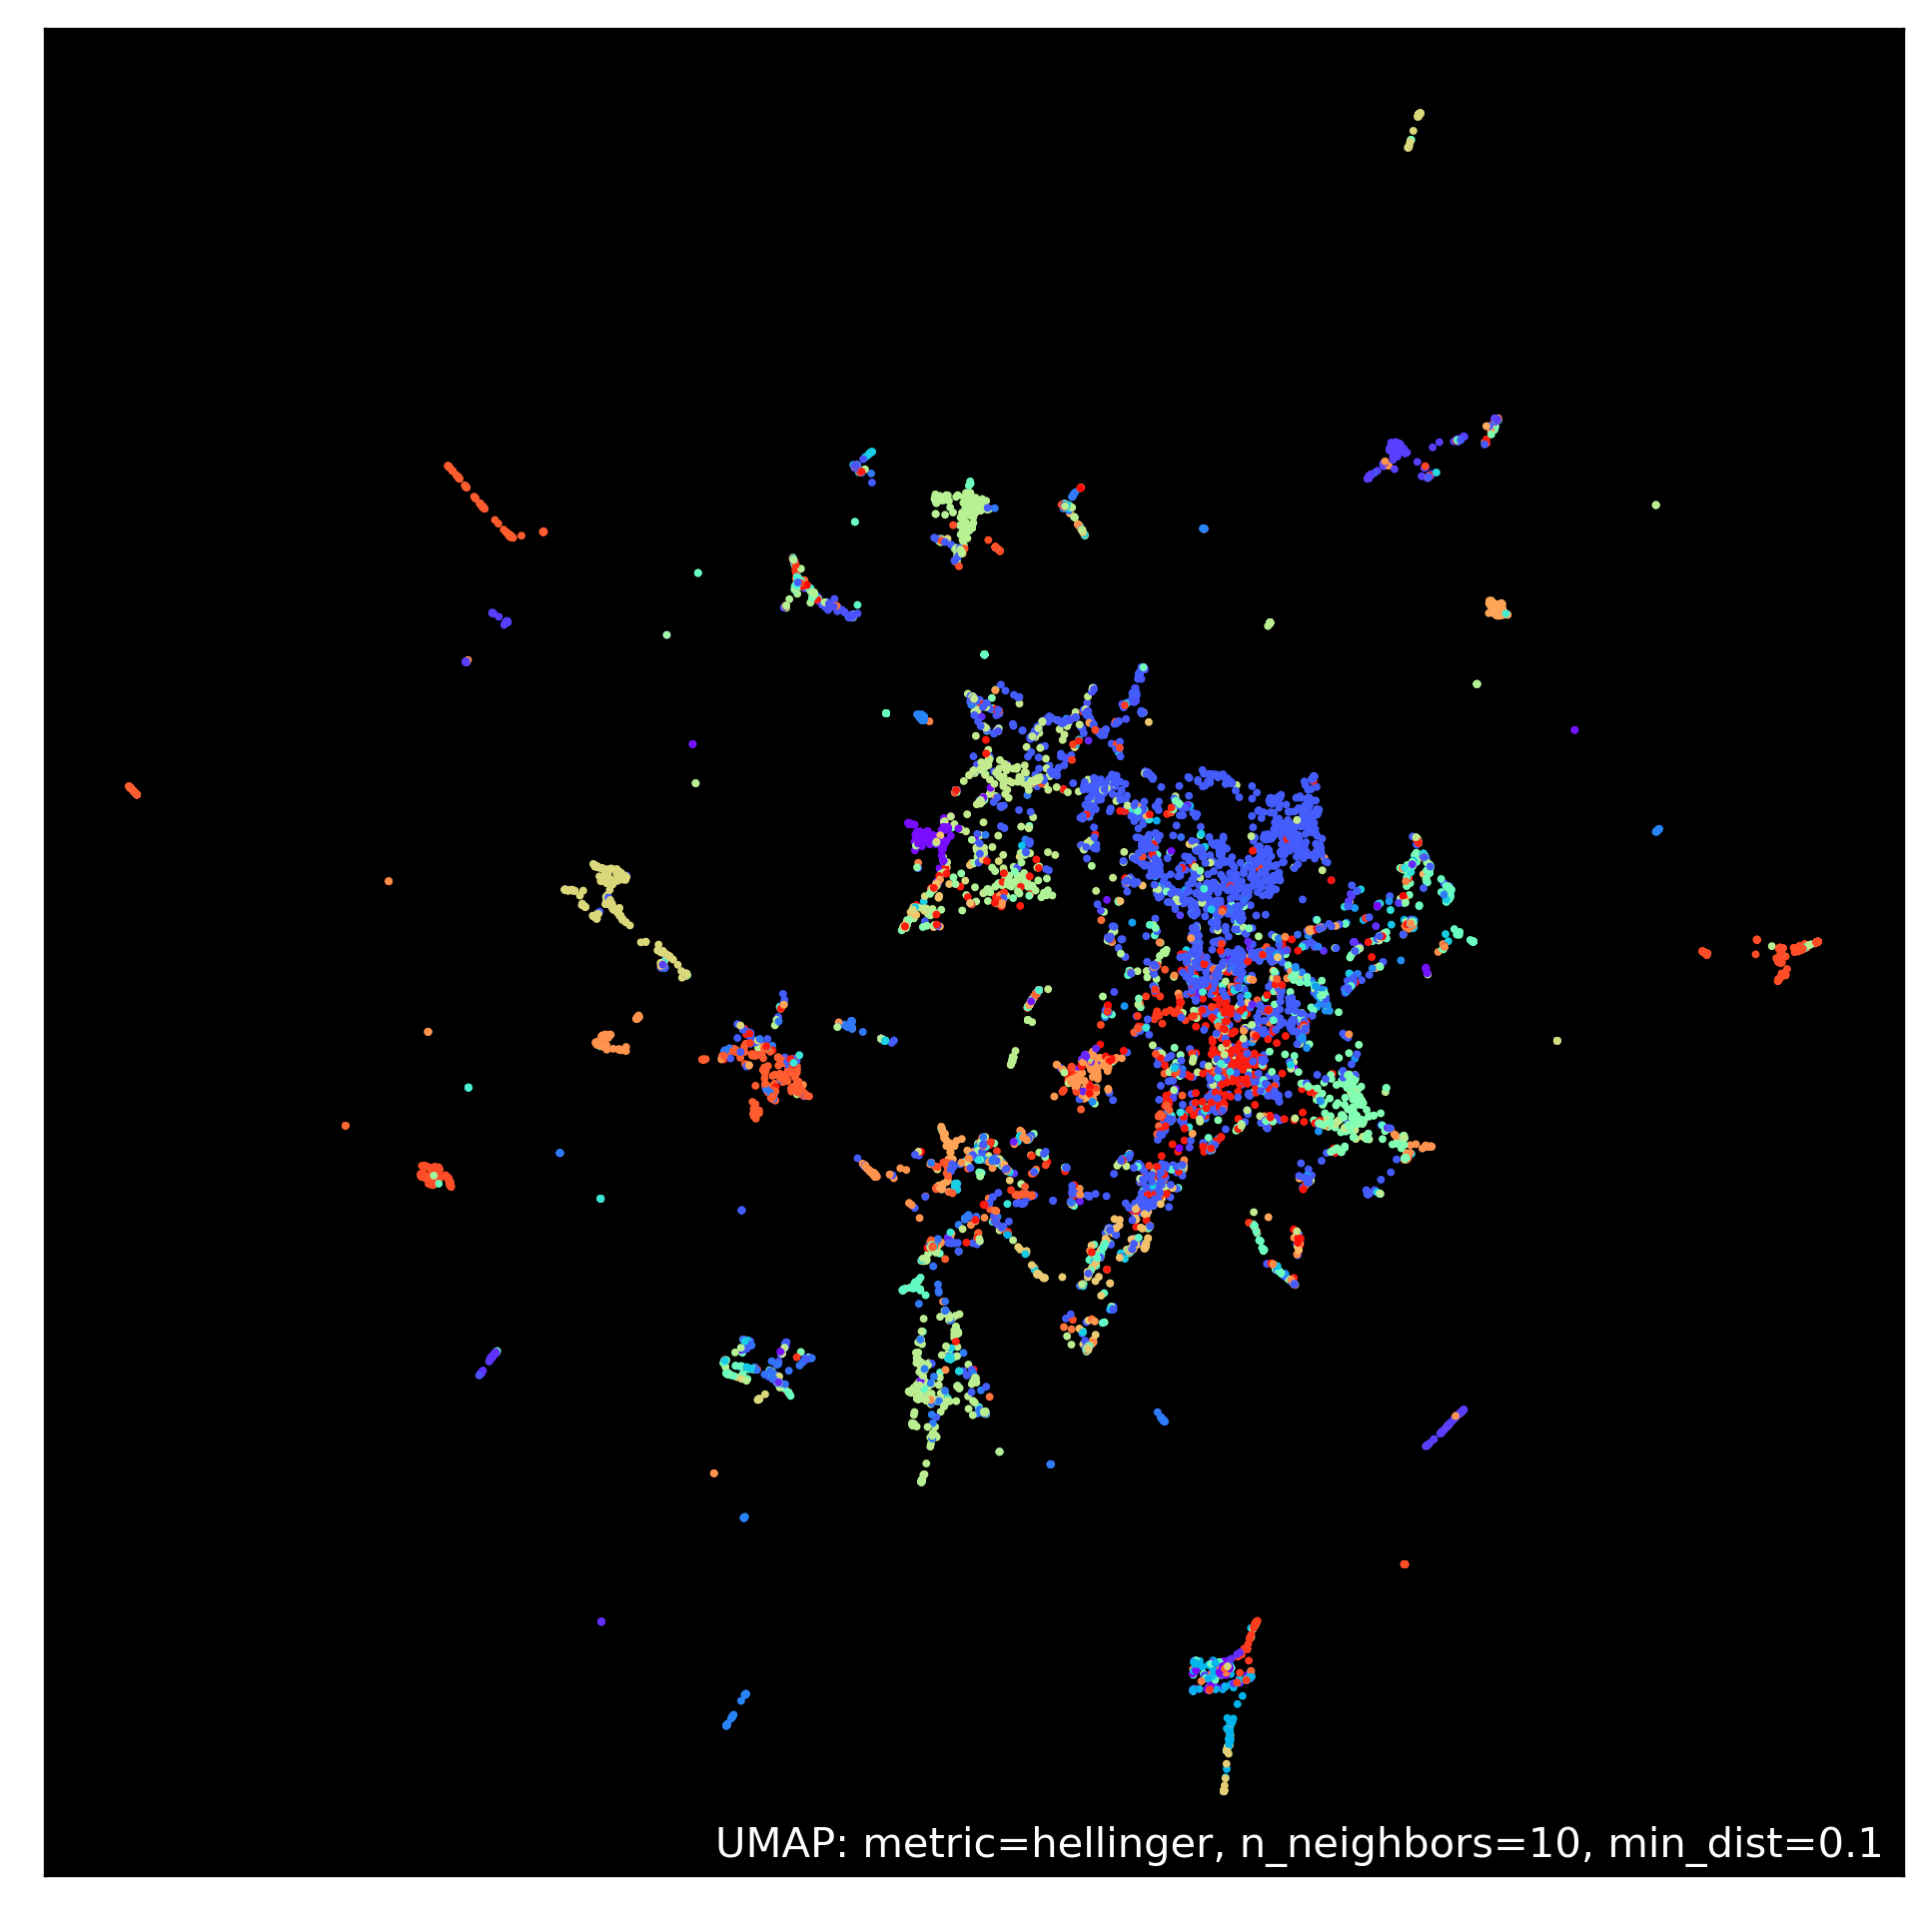

In [ ]:
hover_df = winery[['winery', 'num_reviews', 'country', 'province', 'price', 'points',
                   'num_varietals', 'favourite_varietal']]
f = umap.plot.interactive(winery_by_varietal_model, labels=winery.province.astype(str), 
                          hover_data=hover_df, theme='fire', point_size=5);
#save(f, filename=outfile_html)
show(f)